# Goal: Look at coupling index from CESM1 amip simulations for comparison to CESM2. 
<br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 27 Aug 2020 
<br><br>
<b>Short Description:</b> Ultimate goal is to determine if CLUBB makes a big difference in the coupling metrics. Should be able to tell that (at least roughly) by first looking at a CESM1 amip simulation compared with the CESM2 run analyzed in <i>Coupling_Index.ipynb</i>.
<br>


In [1]:
# Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 

# Plotting utils 
import matplotlib.pyplot as plt 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in data
<u>Note:</u> Pressure level of the LCL height (in hPa above ground) needs to be computed with separate script for the sake of memory. 

In [49]:
# S/glade/work/mdfowler/data/ names (build up with various parts)
#cesm1dir   = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/CESM1/'
cesm1dir = '/glade/work/mdfowler/data/CESM1/'

startCLM = 'cam5.1_amip_1d_002.clm2.h1.'
startCAM = 'cam5.1_amip_1d_002.cam2.h1.'

endCLM = '_soilliqOnly.nc'
endIce = '_soiliceOnly.nc'
endFLX = '_sfcFluxes.nc'

timeName = ['1979-1989', '1990-1999', '2000-2006']


In [3]:
# Read in test file to get lat/lon 
fileName = cesm1dir+startCLM+timeName[0]+endCLM
testDF   = xr.open_dataset(fileName, decode_times=True)

# Get lat and lon 
lat = testDF.lat.values
lon = testDF.lon.values 


In [4]:
# Read in files and get time as usable format 
file1 = cesm1dir+startCAM+timeName[0]+endFLX 
flxDF = xr.open_dataset(file1, decode_times=True)
flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')

file2  = cesm1dir+startCAM+timeName[1]+endFLX 
flxDF2 = xr.open_dataset(file2, decode_times=True) 
flxDF2['time'] = flxDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')

file3  = cesm1dir+startCAM+timeName[2]+endFLX 
flxDF3 = xr.open_dataset(file3, decode_times=True) 
flxDF3['time'] = flxDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')

# Concat in one array 
flux_full  = xr.concat([flxDF,  flxDF2, flxDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if __name__ == '__main__':


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


File 3 finished reading in...


In [5]:
# Read in files and get time as usable format 
file1 = cesm1dir+startCLM+timeName[0]+endCLM 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')
soilDF = soilDF.where(soilDF.levgrnd<2.12193400e-01, drop=True)  # Ignore lower down levels 

file2  = cesm1dir+startCLM+timeName[1]+endCLM 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')
soilDF2 = soilDF2.where(soilDF2.levgrnd<2.12193400e-01, drop=True)

file3  = cesm1dir+startCLM+timeName[2]+endCLM 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')
soilDF3 = soilDF3.where(soilDF3.levgrnd<2.12193400e-01, drop=True)


# Concat in one array 
soil_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  app.launch_new_instance()


File 3 finished reading in...


In [50]:
# Read in files and get time as usable format 
file1 = cesm1dir+startCLM+timeName[0]+endIce 
soilDF = xr.open_dataset(file1, decode_times=True)
soilDF['time'] = soilDF.indexes['time'].to_datetimeindex()
print('File 1 finished reading in...')
soilDF = soilDF.where(soilDF.levgrnd<2.12193400e-01, drop=True)  # Ignore lower down levels 

file2  = cesm1dir+startCLM+timeName[1]+endIce 
soilDF2 = xr.open_dataset(file2, decode_times=True) 
soilDF2['time'] = soilDF2.indexes['time'].to_datetimeindex()
print('File 2 finished reading in...')
soilDF2 = soilDF2.where(soilDF2.levgrnd<2.12193400e-01, drop=True)

file3  = cesm1dir+startCLM+timeName[2]+endIce 
soilDF3 = xr.open_dataset(file3, decode_times=True) 
soilDF3['time'] = soilDF3.indexes['time'].to_datetimeindex()
print('File 3 finished reading in...')
soilDF3 = soilDF3.where(soilDF3.levgrnd<2.12193400e-01, drop=True)

# Concat in one array 
soilIce_full  = xr.concat([soilDF,  soilDF2, soilDF3], dim="time")


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  after removing the cwd from sys.path.


File 1 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.


File 2 finished reading in...


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  app.launch_new_instance()


File 3 finished reading in...


In [6]:
# Load pressure level of LCL (computed separately in Get_LCLpressure.py and saved as pickle file)
lclPath = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CESM1.p'
Plcl    = pickle.load( open( lclPath, "rb" ) )


In [7]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(soil_full['time'].values)


In [54]:
# Read in land fraction 
filePath = '/glade/work/mdfowler/data/CESM1/cam5.1_amip_1d_002.clm2.h1.1979-01-01-00000.nc'
exDF = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan

landArea = exDF.area.values * exDF.landfrac.values


## Get 10 cm soil moisture by itself

In [63]:
# Sum over top 4 levels to get top 11cm of soil water/ice 
soilLiq_11cm = np.nansum(soil_full.SOILLIQ.values,    axis=1)*landMask
soilIce_11cm = np.nansum(soilIce_full.SOILICE.values, axis=1)*landMask

# Get as close to "mrsos" as possible by including liq and ice, and dividing by land area 
soil_11cm = (soilLiq_11cm + soilIce_11cm)

# for iT in range(len(flux_full.time)):
#     soil_11cm[iT,:,:] = soil_11cm / landArea 


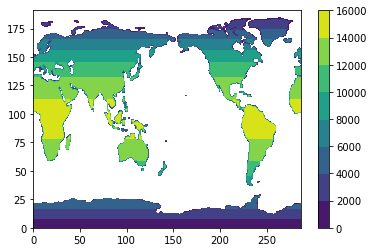

In [62]:
plt.contourf(landArea)
plt.colorbar()

In [69]:
# Mask Greenland and Antarctica (SM = 0 as time mean)
soilMean = np.nanmean(soil_11cm,0)

iceMask = np.ones([len(flux_full.lat.values),len(flux_full.lon.values)])

for i in range(len(flux_full.lat.values)):
    soilMean_sel = soilMean[i,:]
    iceMask[i, soilMean_sel>130] = np.nan
    
    #iceMask[i,:] = iceMask

#soil_11cm[np.nanmean(soil_11cm, axis=0)<0.01] = np.nan


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [71]:
soil_11cm = soil_11cm*iceMask 

## Sanity check: do variables seem reasonable?

Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

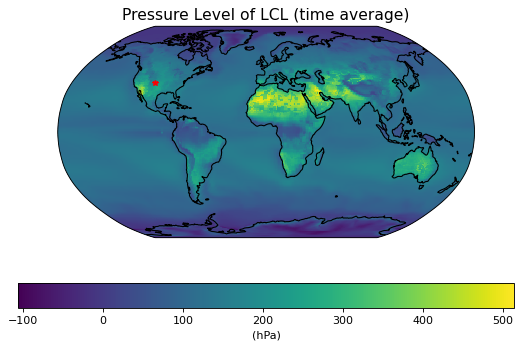

In [14]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)


(726619.0, 726649.0)

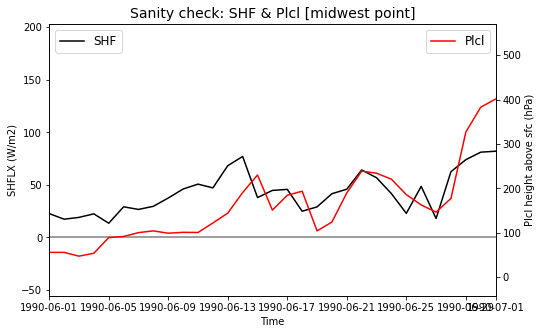

In [15]:
# Plot a timeseries of variables 

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(dates, flux_full.SHFLX[:,135,206],'k-')
ax1.set_ylabel('SHFLX (W/m2)')
ax1.set_xlabel('Time')
ax1.legend(['SHF'],loc='upper left',fontsize=12)
ax1.set_title('Sanity check: SHF & Plcl [midwest point]', fontsize=14)
ax1.axhline(0,color='gray')

ax2 = ax1.twinx()
ax2.plot(dates, Plcl[:,135,206], 'r-')
ax2.set_ylabel('Plcl height above sfc (hPa)')
ax2.legend(['Plcl'], loc='upper right',fontsize=12)

ax1.set_xlim([datetime.date(1990,6,1), datetime.date(1990,7,1)])


Text(0.5, 1.0, 'LHFLX (time mean, 1979-2004)')

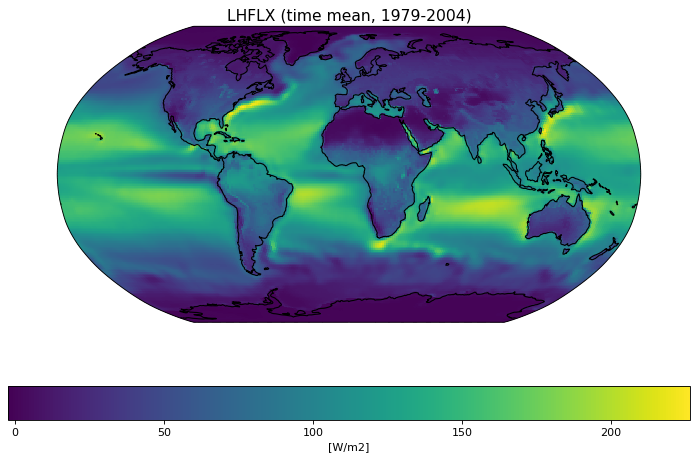

In [16]:
# How about latent heat flux? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
LHavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(flux_full.LHFLX,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,LHavg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[W/m2]',orientation='horizontal')
ax.set_title('LHFLX (time mean, 1979-2004)', fontsize=14)


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '11-cm SM (time mean, 1979-2006)')

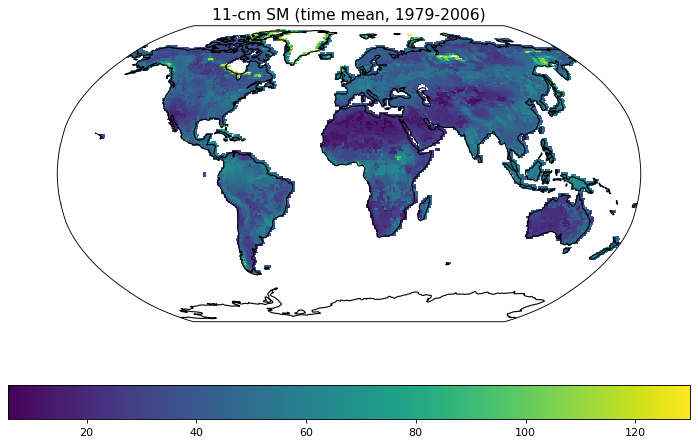

In [70]:
# How about SM? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(soil_11cm,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('11-cm SM (time mean, 1979-2006)', fontsize=14)


## Compute coupling indices: LH & SM

In [78]:
# Make one big xr.Dataset containing all the information we need  
dFull = flux_full
dFull['soilM_10'] = (('time','lat','lon'), soil_11cm)
dFull['Plcl'] = (('time','lat','lon'), Plcl)


In [73]:
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(dFull, xname='soilM_10',yname='LHFLX',averaging='season')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [74]:
# Save to netCDF file
terra_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_CESM1.nc')


Text(0.5, 1.0, 'Terrestrial Coupling Index (11cm SM and LHFLX) [DJF]')

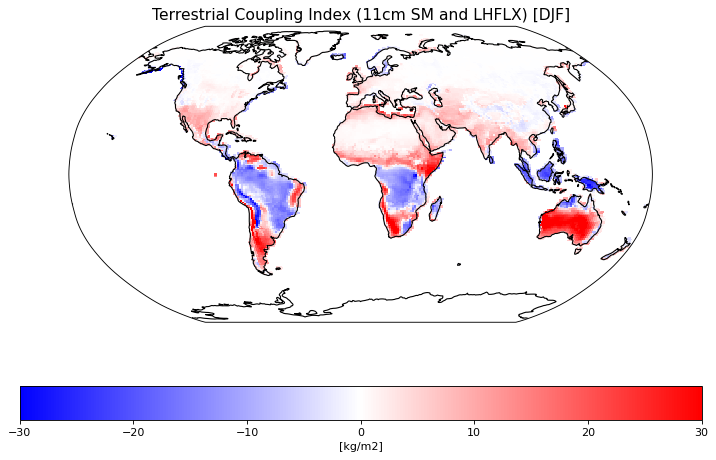

In [75]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
terraCoupl_DJF, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(terra_coupling.soilM_10_LHFLX_CI[0,:,:]), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,terraCoupl_DJF,vmin=-30,vmax=30,cmap='bwr',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[kg/m2]',orientation='horizontal')
ax.set_title('Terrestrial Coupling Index (11cm SM and LHFLX) ['+np.asarray(terra_coupling.season)[0]+']', fontsize=14)



## Compute coupling indices: SH, SM, and P_lcl

In [76]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(dFull, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CESM1.nc')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [79]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(dFull, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/glade/work/mdfowler/scripts//Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CESM1.nc')
